# Introduction

In this notebook we show an analysis of networks of friendship and health advice 
relationships in 17 Ugandan villages.

The goal of the analysis is to show that similarity- and complementarity-driven
structural patterns in networks are statistically associated with different
types of relations and therefore generating processes.

For each of the 17 villages we have two networks - one composed of friendship
relations and one composed of health advice relations. Now, it is sociologically
justifiable to assume that friendship relations 
(being a typical example of relations driven by homophily)
should be associated with statistically significant abundance of similarity
driven patterns. On the other hand, health advice relationships are based
on differences and complementarities between knowledge and information 
of different persons. Hence, they should be driven more by complementarity.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statannotations.Annotator import Annotator
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from src.utils import get_root_path

# AESTHETICS
COLORS = (
    "#EB7159", 
    "#66C8E6", 
    "#AB65B5", 
    "#829F49",
    "#6876CE",
    "#BE8A3B",
    "#CF5786",
    "#AD483A"
) 

sns.set_theme(
    style="ticks",
    font_scale=1.5,
    rc={
        "figure.figsize": (15, 8),
        "font.size": 14,
        "axes.prop_cycle": plt.cycler(color=COLORS),
        "text.latex.preamble": r"\boldmath"
    }
)

ROOT = get_root_path()
HERE = ROOT/"analyses"/"2-social"
DATA = HERE/"data"

FIGPATH = ROOT/"figures"/"social"
FIGPATH.mkdir(exist_ok=True, parents=True)

FIGKWS = dict(bbox_inches="tight", facecolor="white")
PNGKWS = dict(**FIGKWS, dpi=300)
FONTS  = dict(fontsize=18) 

# Get and prepare data frames
social = joblib.load(DATA/"social.pkl.gz")

rdata = pd.concat(social.pop("rawdata").tolist()).reset_index(drop=True)
cdata = pd.concat(social.pop("calibrated").tolist()).reset_index(drop=True)
sdata = pd.concat(social.pop("significant").tolist()).reset_index(drop=True)

rdata = pd.concat([social, rdata], axis=1)
cdata = pd.concat([social, cdata], axis=1)
sdata = pd.concat([social, sdata], axis=1)

## Ugandan villages

### Univariate distributions of structural coefficients

In [2]:
# Auxiliary metadata used later for iterating
# over different coefficients used in analyses.
KEYS = ["relation", "idx"]

SIM = {
    "sim_g":   r"$s$",
    "sim":     r"$\langle{s_i}\rangle$",
}
COMP = {
    "comp_g":  r"$c$",
    "comp":    r"$\langle{c_i}\rangle$",
}
COEFS = { **SIM, **COMP }

# Analysis based on raw coefficients

The first step of our analysis is to look at differences between friendship
and health advice networks based on raw coefficients (i.e. without any calibration).
In this case our intuition is not confirmed as in general differences
between the two types of networks are not strong and at least partially
violate the initial hypothesis.

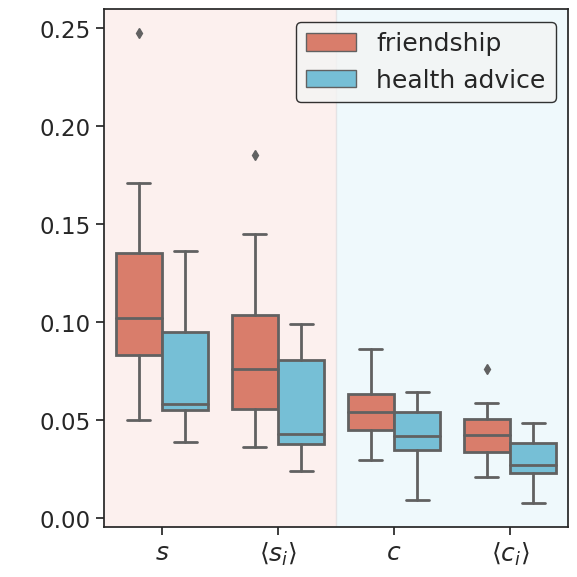

In [3]:
fig, ax = plt.subplots(figsize=(6, 6))

df = rdata.reset_index()[[*KEYS, *COEFS]] \
    .melt(id_vars=KEYS)
    
x    = "variable"
y    = "value"
hue  = "relation"
rels = df["relation"].unique()[::-1]

variables = df[x].unique()
relations = df[hue].unique()

sns.boxplot(x=x, y=y, hue=hue, hue_order=rels, data=df, ax=ax, linewidth=2)
ax.set_xlabel("")
ax.set_ylabel(" ", **FONTS)
labels = { k: v for k, v in COEFS.items() if k in variables }
ax.set_xticklabels([ labels[c] for c in variables ], **FONTS)
ax.legend(title="")

xlim = ax.get_xlim()
ylim = ax.get_ylim()
kwds = dict(zorder=-99, alpha=.1)
ax.fill_between([-1, 1.5], -1, 1, color=COLORS[0], **kwds) 
ax.fill_between([1.5, 5.5], -1, 1, color=COLORS[1], **kwds)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

box  = dict(boxstyle="round", facecolor="white", edgecolor="gray")
kwds = dict(fontweight="bold", fontsize=20, ha="center", bbox=box)

legend = ax.legend(
    ncol=1, frameon=True, 
    edgecolor="black", 
    facecolor="#F4F4F4",
    loc="upper right",
    **FONTS
)

fig.tight_layout()
fig.savefig(FIGPATH/"ugandan-raw.pdf", bbox_inches="tight")

## Differences in terms of first-order structure

However, the two types of networks differ markedly in terms of their
first-order structure (degree sequences and general edge densities).
Since we know that structural coefficients in random networks depend
significantly on node degrees we need to account for this in our analysis.

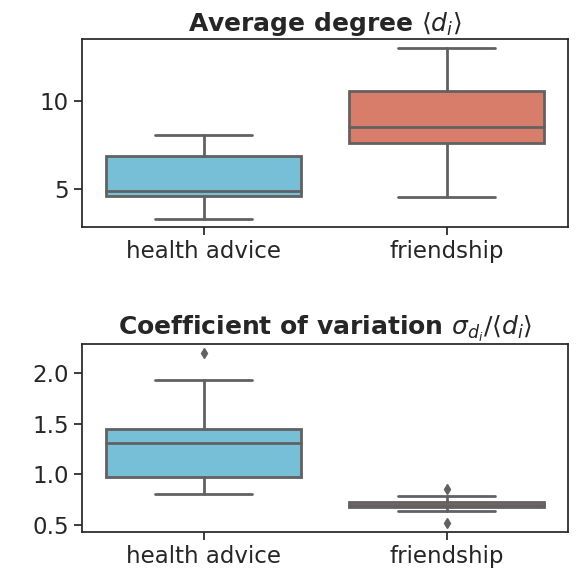

In [4]:
fig, axes = plt.subplots(nrows=2, figsize=(6, 6))
df = rdata.reset_index()

ax = axes[0]
sns.boxplot(
    x="relation", y="dbar", hue="relation", data=df,
    ax=ax, dodge=False, linewidth=2, hue_order=["friendship", "health advice"]
)

ax.set_title(r"Average degree $\langle{d_i}\rangle$", **FONTS, fontweight="bold")
ax.set_xlabel(" ")
ax.set_ylabel(" ")
ax.get_legend().remove()

ax = axes[1]
sns.boxplot(
    x="relation", y="dcv", hue="relation", data=df,
    ax=ax, dodge=False, linewidth=2, hue_order=["friendship", "health advice"]
)

ax.set_title(
    r"Coefficient of variation $\sigma_{d_i}/\langle{d_i}\rangle$", 
    **FONTS, fontweight="bold"
)
ax.set_xlabel("")
ax.set_ylabel("")
ax.get_legend().remove()

fig.tight_layout()
fig.savefig(FIGPATH/"ugandan-1st-order-structure.pdf", bbox_inches="tight")

# Accounting for first-order structure

To account for the differences in first-order structure we calibrate observed
structural coefficients by calculating their ratios (in log scale) relative
to their null distribution assuming the soft configuration model.

For each observed network we sampled $500$ randomized realizations and
for each the ratio of the observed value relative to the randomized value
was calculated. Then, average differences between log-ratios for different
structural coefficients per network were calculated and finally they were
used to estimate average difference between friendship and health advice
networks. Significance was assessed using one sample $t$ test with
Holm-Sidak correction for multiple testing.

In [5]:
data = cdata.set_index(KEYS)[[*COEFS]]
diff = (data.loc["friendship"] - data.loc["health advice"])

In [6]:
def test_difference(data, mu=0, alternative="greater"):
    """Test difference between observed and expected mean
    using one-sample t-test.

    The function runs a separate test for each column in `data`.
    """
    return data.melt() \
        .groupby("variable") \
        .apply(lambda df: pd.Series(
            data=[
                df["value"].mean(),
                *ttest_1samp(df["value"], popmean=mu, alternative=alternative)
            ],
            index=["delta", "t", "pvalue"]
        ))

In [7]:
simcols  = [ *SIM ] 
compcols = [ *COMP ] 

tests = pd.concat([
    diff[simcols].pipe(test_difference, alternative="two-sided"),
    diff[compcols].pipe(test_difference, alternative="two-sided")
]) \
    .assign(pvalue=lambda df: \
        sm.stats.multipletests(df["pvalue"], method="holm")[1]
    )

# Results

We see that after proper calibration the results are perfectly congruent
with the theoretical expectations. Friendship networs are driven by similarity
to a significantly larger extent than health advice networks and to similarily
to a lower extent by complementarity.

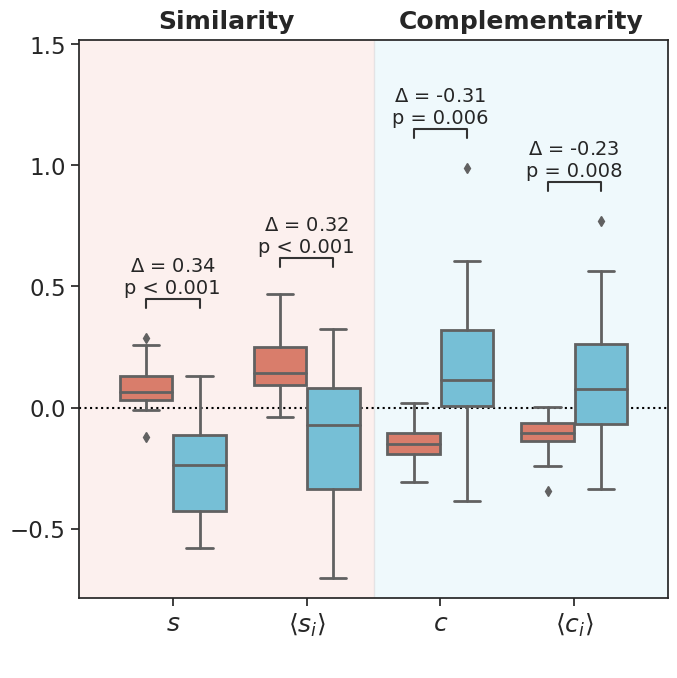

In [10]:
fig, ax = plt.subplots(figsize=(7, 7))

df = data[[*COEFS]] \
    .reset_index(KEYS, drop=False) \
    .reset_index(drop=True) \
    .melt(id_vars=KEYS) \
    .groupby(["relation", "idx", "variable"]) \
    .mean() \
    .reset_index()

x   = "variable"
y   = "value"
hue = "relation"

variables = list(COEFS)
relations = df[hue].unique()
labels = { k: v for k, v in COEFS.items() if k in variables }

ddf     = tests.loc[variables]
deltas  = ddf["delta"].values
pvalues = ddf["pvalue"].values

annotations = []
for d, p in zip(deltas, pvalues):
    ps = "p < 0.001" if p < .001 else f"p = {p:.3f}"
    a = r"$\Delta$" + f" = {d:.2f}\n{ps}"
    annotations.append(a)

sns.boxplot(x=x, y=y, hue=hue, data=df, ax=ax, linewidth=2, order=variables)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels([ labels[c] for c in variables ], **FONTS)

ax.get_legend().remove()
ax.axhline(0, ls=":", color="black", zorder=-10)

box_pairs = []
for c in labels:
    box_pairs.append([ (c, r) for r in relations ])

annotator = Annotator(ax, box_pairs, data=df, x=x, y=y, hue=hue, order=variables)
annotator.configure(verbose=False)
annotator.set_custom_annotations(annotations)
annotator.annotate()

xlim   = ax.get_xlim()
y0, y1 = ax.get_ylim()
ylim   = (y0, y1*1.1)
kwds   = dict(zorder=-99, alpha=.1)
ax.fill_between([-1, 1.5], -1, 12, color=COLORS[0], **kwds) 
ax.fill_between([1.5, 6], -1, 12, color=COLORS[1], **kwds)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel(" ", **FONTS, fontweight="bold")

kwds = { **FONTS, "transform": ax.transAxes, "ha": "center", "fontweight": "bold" }
ax.text(0.25, 1.02, "Similarity", **kwds)
ax.text(.75, 1.02, "Complementarity", **kwds)

fig.tight_layout()
fig.savefig(FIGPATH/"ugandan-correct.pdf", bbox_inches="tight")

## Predictive power

In oreder to gauge the predictive power of our result we fitted
a simple qudratic discriminant model for based only on global similarity
and complementarity coefficients. As we see below, it yields a remarkably
good predictive power based on accuracy with $17$-fold stratified 
cross-validation.

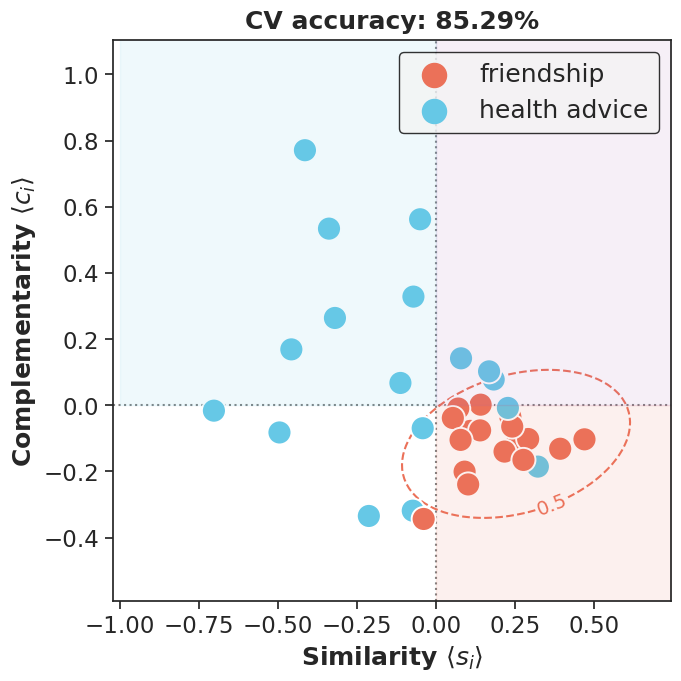

In [12]:
FEATURES = ["sim", "comp"]
ORDER    = ["friendship", "health advice"]

gdf = data[FEATURES]
X = gdf.values
y, labels = gdf.index.get_level_values(0).factorize()

cv = StratifiedKFold(n_splits=17)
perf = np.zeros((cv.get_n_splits(X)), dtype=float)
for i, split in enumerate(cv.split(X, y)):
    train_idx, test_idx = split
    qda = QuadraticDiscriminantAnalysis()
    qda.fit(X[train_idx], y[train_idx])
    pred = qda.predict(X[test_idx])
    a = np.mean(pred == y[test_idx])
    perf[i] = a

acc = perf.mean()
acc

qda = QuadraticDiscriminantAnalysis()
qda.fit(X, y)

x, y = FEATURES

x0, y0 = X.min(axis=0) - .15
x1, y1 = X.max(axis=0) + .15

xx, yy = np.meshgrid(np.linspace(x0, x1, 100), np.linspace(y0, y1, 100))
pred = qda.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0].reshape(xx.shape)
pred = np.round(pred, 3)

fig, ax = plt.subplots(figsize=(7, 7))
contours = ax.contour(
    xx, yy, pred, levels=[.5], linestyles="dashed", colors=COLORS[0],
    zorder=-1
)
plt.clabel(contours)

df = gdf.reset_index()

sns.scatterplot(
    x=x, y=y, data=df,
    hue="relation", hue_order=ORDER,
    s=300, ax=ax, edgecolors="white"
)

expand = 1.2
ax.set_xlim([ x*expand for x in ax.get_xlim() ])
ax.set_ylim([ y*expand for y in ax.get_ylim() ])

ax.axvline(0, ls=":", color="gray", zorder=-100)
ax.axhline(0, ls=":", color="gray", zorder=-100)

ax.get_legend().remove()


legend = ax.legend(**FONTS, edgecolor="black", facecolor="#F4F4F4", loc="upper right")
legend.set_title("")
for handle in legend.legendHandles:
    handle.set_sizes([300])

kwds   = { **FONTS, "fontweight": "bold", "ha": "center", "transform": ax.transAxes}
header = f"CV accuracy: {100*acc:.2f}%"

ax.text(.5, 1.02, header, **kwds)

ax.set_xlabel(
    r"Similarity $\langle{}s_i{}\rangle$", 
    **FONTS, fontweight="bold"
)
ax.set_ylabel(
    r"Complementarity $\langle{}c_i{}\rangle$", 
    **FONTS, fontweight="bold"
)


ax.fill_between([0, 1], [0, 0], [-1, -1], alpha=.1, color=COLORS[0])
ax.fill_between([-1, 0], [0, 0], [2, 2], alpha=.1, color=COLORS[1])
ax.fill_between([0, 1], [0, 0], [2, 2], alpha=.1, color=COLORS[2])

fig.tight_layout(pad=1)
fig.savefig(FIGPATH/"ugandan-decision.pdf", bbox_inches="tight")